<a href="https://colab.research.google.com/github/Ishita7078/test_tpu/blob/main/GPUvsTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why TPUs ?

TPUs are tensor processing units developed by Google to  accelerate operations on a Tensorflow Graph. Each TPU packs up to 180 teraflops of floating-point performance and 64 GB of high-bandwidth memory onto a single board. Here is a comparions between TPUs and Nvidia GPUs. The y axis represents # images per seconds and the x axis is different models.

<img src="https://cdn-images-1.medium.com/max/800/1*tVHGjJHJrhKaKECT3Z4CIw.png" alt="Drawing" style="width: 150px;"/>

# Experiement

TPUs were only available on Google cloud but now they are available for free in Colab. We will be comparing TPU vs GPU here on colab using mnist dataset. We will compare the time of each step and epoch against different batch sizes.

# Downoad MNIST

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

def get_data():

  #Load mnist data set
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  x_train = np.expand_dims(x_train, 3)
  x_test = np.expand_dims(x_test, 3)

  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return x_train, y_train, x_test, y_test

# Basic CNN

Note that since we need to run the code on TPU we need to do more work. We need to specify the address of the TPU and tell tensorflow to run the model on the TPU cluster

In [ ]:
from tensorflow.contrib.tpu.python.tpu import keras_support

def get_model(tpu = False):
  model = tf.keras.Sequential()

  #add layers to the model
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  #compile the model
  model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

  #flag to run on tpu
  if tpu:
    tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]

    #connect the TPU cluster using the address
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)

    #run the model on different clusters
    strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)

    #convert the model to run on tpu
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
  return model

#GPU vs TPU


In [ ]:
x_train, y_train, x_test, y_test = get_data()

Each time you want to run the model on TPU make sure to set the tpu flag and change the enviornment runtime via  Edit> Notebook Setting > Hardware Accelerator > TPU and then click save.

In [ ]:
#set tpu = True if you want to run the model on TPU
model = get_model(tpu = False)

In [ ]:
model.fit(x_train,
         y_train,
         batch_size=1024,
         epochs=10,
         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2s 38us/step - loss: 0.1639 - acc: 0.9513 - val_loss: 0.0677 - val_acc: 0.9752
Epoch 2/3
60000/60000 [==============================] - 2s 35us/step - loss: 0.1345 - acc: 0.9573 - val_loss: 0.0552 - val_acc: 0.9808
Epoch 3/3
60000/60000 [==============================] - 2s 40us/step - loss: 0.1189 - acc: 0.9619 - val_loss: 0.0443 - val_acc: 0.9848


# Benchmarks

Note that TPU setup takes some time when compiling the model and distributing the data in the clusters, so the first epoch will take alonger time. I only reported the time for the later epochs. I calculated the average time accross different epochs.

### Epoch Time ($s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 6s & 6s\\  
 512 & 5s & 3s\\
 1024 & 4s & 2s\\
\end{array}\right]$$

### Step Time ($\mu s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 94 \mu s & 97 \mu s\\  
 512 & 82 \mu  s& 58 \mu s \\
 1024 & 79 \mu s & 37 \mu s\\
\end{array}\right]$$

# References



*   https://qiita.com/koshian2/items/25a6341c035e8a260a01
*   https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a
*   https://blog.riseml.com/benchmarking-googles-new-tpuv2-121c03b71384
*   https://cloudplatform.googleblog.com/2018/02/Cloud-TPU-machine-learning-accelerators-now-available-in-beta.html



In [66]:
import os, time
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

assert any(d.platform == "tpu" for d in jax.devices()), "Not using TPU"
print(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]


In [67]:
BASE = "/"


In [68]:
def mat_path(N):
    return os.path.join(BASE, f"matrix_float64_{N}.bin")

def vec_path(N):
    return os.path.join(BASE, f"vector_float64_{N}.csv")

def load_matrix(N):
    return np.fromfile(mat_path(N), dtype=np.float64).reshape(N, N).astype(np.float32, copy=False)

def load_vector(N):
    return np.loadtxt(vec_path(N), dtype=np.float64).astype(np.float32, copy=False)

In [70]:
REAL_SIZES  = [2131, 4262, 8524]
TILED_SIZES = [17048, 34096]

base_matrix = load_matrix(8524)
print("base_matrix:", base_matrix.shape, base_matrix.dtype)


base_matrix: (8524, 8524) float32


In [88]:
@jax.jit
def mvm_full(A, x):
    return A @ x

def bench_full(A_fp32, x_fp32, jax_dtype):
    A = jax.device_put(jnp.asarray(A_fp32, dtype=jax_dtype))
    x = jax.device_put(jnp.asarray(x_fp32, dtype=jax_dtype))

    #warm-up compile
    y = mvm_full(A, x)
    y.block_until_ready()

    #matmul timed
    t0 = time.perf_counter()
    y = mvm_full(A, x)
    y.block_until_ready()
    return float((time.perf_counter() - t0) * 1000.0)


In [76]:
def _tiled_matvec_kernel(base_A, x_big, *, N: int, block_r: int, block_c: int):
    n0 = base_A.shape[0]

    def row_body(i, y_out):
        row0 = i * block_r
        br = jnp.minimum(block_r, N - row0)

        rows = row0 + jnp.arange(block_r)
        rows_mod = jnp.mod(rows, n0)

        def col_body(j, acc):
            col0 = j * block_c
            cols = col0 + jnp.arange(block_c)
            cols_mod = jnp.mod(cols, n0)

            A_rows = jnp.take(base_A, rows_mod, axis=0)
            A_sub  = jnp.take(A_rows, cols_mod, axis=1)

            x_sub = jax.lax.dynamic_slice(x_big, (col0,), (block_c,))
            acc = acc + (A_sub @ x_sub)
            return acc

        acc0 = jnp.zeros((block_r,), dtype=base_A.dtype)
        n_col_blocks = (N + block_c - 1) // block_c
        acc = jax.lax.fori_loop(0, n_col_blocks, col_body, acc0)

        acc = jnp.where(jnp.arange(block_r) < br, acc, 0.0)
        y_out = jax.lax.dynamic_update_slice(y_out, acc, (row0,))
        return y_out

    y0 = jnp.zeros((N,), dtype=base_A.dtype)
    n_row_blocks = (N + block_r - 1) // block_r
    return jax.lax.fori_loop(0, n_row_blocks, row_body, y0)

_tiled_matvec_kernel_jit = jax.jit(
    _tiled_matvec_kernel,
    static_argnames=("N", "block_r", "block_c"),
)

def bench_tiled_one_shot(base_matrix_fp32, N, jax_dtype, block_r, block_c):
    base_A = jax.device_put(jnp.asarray(base_matrix_fp32, dtype=jax_dtype))
    x_np = load_vector(N)
    x_big = jax.device_put(jnp.asarray(x_np, dtype=jax_dtype))

    #warm-up compile
    y = _tiled_matvec_kernel_jit(base_A, x_big, N=N, block_r=block_r, block_c=block_c)
    y.block_until_ready()

    #full matvec timed
    t0 = time.perf_counter()
    y = _tiled_matvec_kernel_jit(base_A, x_big, N=N, block_r=block_r, block_c=block_c)
    y.block_until_ready()
    return float((time.perf_counter() - t0) * 1000.0)


In [86]:
dtypes = [
    ("FP32", jnp.float32),
    ("BF16", jnp.bfloat16),
]

TILE_PARAMS = {
    17048: dict(block_r=256, block_c=1024),
    34096: dict(block_r=256,  block_c=1024),
}

results = {name: {"N": [], "time_ms": []} for name, _ in dtypes}

for name, jdtype in dtypes:
    print(f"{name}")

    for N in REAL_SIZES:
        A_fp32 = load_matrix(N)
        x_fp32 = load_vector(N)
        t_ms = bench_full(A_fp32, x_fp32, jdtype)
        results[name]["N"].append(N)
        results[name]["time_ms"].append(t_ms)
        print(f"N={N:5d}  time={t_ms:10.3f} ms")

    for N in TILED_SIZES:
        p = TILE_PARAMS[N]
        t_ms = bench_tiled_one_shot(base_matrix, N, jdtype, **p)
        results[name]["N"].append(N)
        results[name]["time_ms"].append(t_ms)
        print(f"N={N:5d}  time={t_ms:10.3f} ms")


FP32
N= 2131  time=     0.308 ms
N= 4262  time=     0.348 ms
N= 8524  time=     0.730 ms
N=17048  time=    10.145 ms
N=34096  time=    35.075 ms
BF16
N= 2131  time=     0.270 ms
N= 4262  time=     0.552 ms
N= 8524  time=     0.830 ms
N=17048  time=    12.841 ms
N=34096  time=    44.933 ms


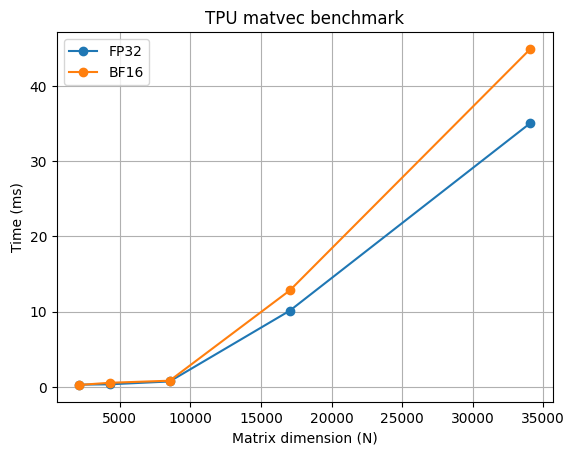

In [87]:
plt.figure()
for name, _ in dtypes:
    Ns = np.array(results[name]["N"], dtype=int)
    ts = np.array(results[name]["time_ms"], dtype=float)
    order = np.argsort(Ns)
    plt.plot(Ns[order], ts[order], marker="o", label=name)

plt.xlabel("Matrix dimension (N)")
plt.ylabel("Time (ms)")
plt.title("TPU matvec benchmark")
plt.legend()
plt.grid(True)
plt.show()
